## The only difference between weakly supervised and self supervised RW-PINN code is the  RW-PINN loss function

In [1]:
#!pip install wiggle
#!pip install tensorflow-addons
#!pip install tensorflow-probability
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from sklearn.metrics import mean_squared_error
#from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import pandas as pd
import sys
import os

In [2]:
#!pip install pydot

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
#from keras.utils import layer_utils, normalize
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.utils import np_utils, normalize
from keras.utils import np_utils
from keras.backend import manual_variable_initialization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
#import pydot

C:\Users\divakarv\AppData\Local\Temp/ipykernel_604/3049612121.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  src_len=np.int(60)


Text(0.5, 1.0, 'Source Wavelet')

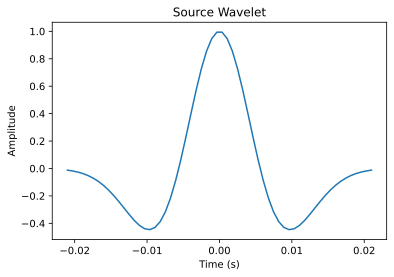

In [3]:
def ricker_wav(f,n,dt,t0):
    T = dt*(np.floor(n/2))
    t = np.linspace(-T,T,n)
    tau = t-t0
    pi=np.pi
    s = (1-2*tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2)
    rw = s
    return rw,t
 
freq=40
dt=7e-4
src_len=np.int(60)
wvlt,tt = ricker_wav(freq,src_len,dt,0)
plt.plot(tt,wvlt)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")

In [4]:
def SoftSandNew(Kf,RHOf,Phi,Quartz,Clay,Feldspar,Limestone,Dolomite,Pressure,PhiC,Coordination,Fudge):
    # Uncemented sand rock physics model (modified to implement automatic-differentiation)
    #               INPUTS
    #
    #Kf				Fluid bulk modulus
    #RHOB			Fluid density
    #Phi			Porosity (fraction)
    #Quartz, etc.	Volume mineral content in solid phase (fraction)
    #Pressure		Effective pressure (MPa)
    #PhiC			Critical porosity ~0.4
    #Coordination	Coordination number ~6
    #Fudge			Reduction in shear stiffness -- 1 by default
    #
    #a is the contact radius between two spheres at input pressure

    #Balancing mineralogy
    Dolomite=1-(Quartz+Clay+Feldspar+Limestone)
    
    #Constants for clay
    RHOClay=2.65 
    KClay=21 
    GClay=7
    #Solid-phase elastic moduli
    KsV=Quartz*36.6+Clay*KClay+Limestone*76.8+Dolomite*94.9+Feldspar*75.6
    KsR=1/(Quartz/36.6+Clay/KClay+Limestone/76.8+Dolomite/94.9+Feldspar/75.6)
    Ks=0.5*(KsV+KsR)
    
    GsV=Quartz*45+Clay*GClay+Limestone*32+Dolomite*45+Feldspar*25.6
    GsR=1/(Quartz/45+Clay/GClay+Limestone/32+Dolomite/45+Feldspar/25.6)
    Gs=0.5*(GsV+GsR)
    Ms=Ks+(4/3)*Gs
    NUs=0.5*(Ms/Gs-2)/(Ms/Gs-1)
    
    #Solid-phase density
    RHOs=Quartz*2.65+Clay*RHOClay+Limestone*2.71+Dolomite*2.87+Feldspar*2.63
    
    #ILLITE
    #RHOs=2.58; Ms=RHOs.*4.32.*4.32; Gs=RHOs.*2.54.*2.54; NUs=0.5*(Ms./Gs-2)./(Ms./Gs-1); Ks=Ms-(4/3)*Gs;
    
    P=Pressure/1000
    C=Coordination
    
    #================== Dry Rock ====================
    #Effective K and G at PhiC
    #Hertz contact radius (R=1)
    a=tf.pow(((3*3.14*(1-NUs)/(2*C*(1-PhiC)*Gs))*P),(1/3))
    #Normal contact stiffness
    SN=4*a*Gs/(1-NUs)
    #Shear contact stiffness
    ST=8*a*Gs/(2-NUs)
    #Shear contact stiffness FUDGED (reduced)
    ST=ST/Fudge
    
    #Bulk modulus
    Khat=C*(1.-PhiC)*SN/(12*3.14)
    #Shear modulus
    Ghat=C*(1.-PhiC)*(SN+1.5*ST)/(20*3.14)
    
    #Effective bulk and shear moduli at porosity Phi<=PhiC
    KDry1=1/((Phi/PhiC)/(Khat+4*Ghat/3)+((PhiC-Phi)/PhiC)/(Ks+4*Ghat/3))-4*Ghat/3
    ZZ1=(Ghat/6)*(9*Khat+8*Ghat)/(Khat+2*Ghat)
    GDry1=1/((Phi/PhiC)/(Ghat+ZZ1)+((PhiC-Phi)/PhiC)/(Gs+ZZ1))-ZZ1
    MDry1 = KDry1+(4/3)*GDry1
    NuDry1=0.5*(MDry1/GDry1-2)/(MDry1/GDry1-1)
    
    #Effective bulk and shear moduli at porosity Phi>PhiC
    KDry2 = 1/(((1-Phi)/(1-PhiC))/(Khat+4*Ghat/3)+((Phi-PhiC)/(1-PhiC))/(4*Ghat/3))-4*Ghat/3
    ZZ2 = (Ghat/6)*(9*Khat+8*Ghat)/(Khat+2*Ghat)
    GDry2 = 1/(((1-Phi)/(1-PhiC))/(Ghat+ZZ2)+((Phi-PhiC)/(1-PhiC))/(ZZ2))-ZZ2
    MDry2 = KDry2+(4/3)*GDry2
    NuDry2=0.5*(MDry2/GDry2-2)/(MDry2/GDry2-1)
    
    MDry=MDry1*(tf.cast((Phi<=PhiC), tf.float64))+MDry2*(tf.cast((Phi>PhiC), tf.float64)) 
    GDry=GDry1*(tf.cast((Phi<=PhiC), tf.float64))+GDry2*(tf.cast((Phi>PhiC), tf.float64))
    NuDry=NuDry1*(tf.cast((Phi<=PhiC), tf.float64))+NuDry2*(tf.cast((Phi>PhiC), tf.float64))
    KDry=MDry-(4/3)*GDry
    
    # ================== Saturated Rock ============
    KSat=Ks*(Phi*KDry-(1+Phi)*Kf*KDry/Ks+Kf)/((1-Phi)*Kf+Phi*Ks-Kf*KDry/Ks)
    MSat=KSat+(4/3)*GDry
    RHOB=(1-Phi)*RHOs+Phi*RHOf
    Vp=tf.pow((MSat/RHOB),0.5)
    Vs=tf.pow((GDry/RHOB),0.5)
    Ip=Vp*RHOB
    PR=0.5*(MSat/GDry-2)/(MSat/GDry-1)
    
    return Vp,Vs,RHOB

In [5]:
def RC_fwd_model(vp1,d1,vp2,d2):
    
    Rpp= (vp2*d2-vp1*d1)/(vp2*d2+vp1*d1)
    
    return Rpp

In [6]:
Kg = 0.06
Kw = 2.61
RHOw = 1.01
RHOg = 0.18 
diffP = 16.5 
RHOs = 2.65
PhiC = 0.4 
Coordination = 14 
Fudge = 1
diffDepth = 1

# We have not analyzed the impact of partialsaturations or the presence of clay on the predictions
vclay=tf.cast(0,tf.float64)
sw=tf.cast(1,tf.float64)

In [7]:
seis=np.load("seismic_data.npy") ##seismic data
phi_true=np.load("porosity_data.npy") ##porosity data

In [8]:
phi_max=np.max(phi_true) #can also take 1 or critical porosity (0.4)
phi_min=np.min(phi_true) #can also take 0

In [9]:
# Normalizing the input and output data  

seis_normalized = (seis - np.min(seis))/(np.max(seis)-np.min(seis))

#seis_compiled=np.concatenate((seis_normalized[:,0,:],seis_normalized[:,1,:]),axis=1)
seis_compiled=seis_normalized

true_output=np.zeros((seis_normalized.shape[0],199))
true_output[:,0:199]=(phi_true-phi_min)/(phi_max-phi_min)

seis_plus_petro_compiled=np.concatenate((seis_compiled,true_output),axis=1)

X_train,X_test,Y_train_unmasked,Y_test_unmasked = sklearn.model_selection.train_test_split(seis_normalized,seis_plus_petro_compiled, test_size=0.2, random_state=1)

X_train_final = np.expand_dims(np.expand_dims(X_train, axis=1),axis=3)
X_test_final = np.expand_dims(np.expand_dims(X_test, axis=1),axis=3)
mask_output_test=Y_test_unmasked[:,0:1]-Y_test_unmasked[:,0:1]
Y_test=np.concatenate((Y_test_unmasked,mask_output_test),axis=1)
mask_output_train=Y_train_unmasked[:,0:1]-Y_train_unmasked[:,0:1]
mask_no=4 ##number of prior known porosity logs
mask_output_train[0:mask_no,:]=1
Y_train=np.concatenate((Y_train_unmasked,mask_output_train),axis=1)

print ("number of training examples = " + str(X_train_final.shape[0]))
print ("number of test examples = " + str(X_test_final.shape[0]))
print ("X_train shape: " + str(X_train_final.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test_final.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 1, 246, 1)
Y_train shape: (2000, 446)
X_test shape: (500, 1, 246, 1)
Y_test shape: (500, 446)


In [10]:
## Denominators for normalizing the RMS error in the loss function
denom_phi= tf.reduce_sum(tf.where(Y_train[:,-1] ==1,tf.reduce_mean(Y_train[:,246:246+199],axis=1), Y_train[:,-1]))/mask_no
np.save("denom_phi.npy",denom_phi)

denom_seis= tf.reduce_mean(X_train)
np.save("denom_seis.npy",denom_seis)

Text(0.5, 0, 'After normalisation')

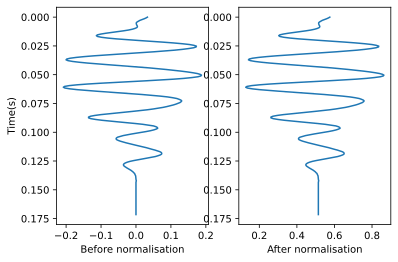

In [11]:
end_time=0.172
time_upscaled = np.arange(0, end_time, dt)

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis[3,:]),time_upscaled)
plt.gca().invert_yaxis()
plt.ylabel('Time(s)')
plt.xlabel('Before normalisation')

plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_normalized[3,:]),time_upscaled)
plt.gca().invert_yaxis()
plt.xlabel('After normalisation')

In [12]:
def DecoderLinearInterpLayer(x,xp,fp):
    i = tf.clip_by_value(tf.searchsorted(xp, x, side='right'), 1, xp.shape[1] - 1)

    fp1=tf.gather(fp,indices=i-1, batch_dims=1)
    fp2=tf.gather(fp,indices=i, batch_dims=1)
    xp1=tf.gather(xp,indices=i-1, batch_dims=1)
    xp2=tf.gather(xp,indices=i, batch_dims=1)

    f = (fp1 *  (xp2 - x) + fp2 * (x - xp1)) / (xp2 - xp1)

    left=fp[0,0]
    right = fp[-1,-1]

    ff = tf.where(x < tf.ones_like(x)*tf.expand_dims(xp[:,0],axis=1), left, f)
    fff = tf.where(x > tf.ones_like(x)*tf.expand_dims(xp[:,-1],axis=1), tf.ones_like(x)*tf.expand_dims(fp[:,-1],axis=1), ff)
    return fff

In [13]:
given_seed = 2

input_final = Input(shape=(X_train_final.shape[1:]))

# Encoder
#1
X = Conv2D(32, (1, 3), strides=(1, 2), name='conv0', padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(input_final)

#X = BatchNormalization(axis=-1, name='bn0')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv0')(X)

#2
X = Conv2D(64, (1, 7), strides=(1, 2), name='conv1',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn1')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv1')(X)

#3
X = Conv2D(128, (1, 15), strides=(1, 2), name='conv2',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn2')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv2')(X)

#4 
X = Conv2D(256, (1, 30), strides=(1, 2), name='conv3',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)
          
#X = BatchNormalization(axis=-1, name='bn3')(X)
X = Activation('relu')(X)
X = Dropout(rate=0.3, name='drop_conv3')(X)

# FLATTEN X + FULLYCONNECTED
X = Flatten()(X)
    
X = Dense(199, name='fc0',
          kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

encoded = Activation('tanh')(X) ##to scale the output between –1 and 1 before passing it as input to the decoder

# Decoder
encoded=tf.cast(encoded, tf.float64)

phi_for=((encoded + 1)/2) ##scaled between 0 and 1

phi=phi_for * (phi_max - phi_min) + phi_min + 1e-07

depth = np.arange(1,phi.shape[1]+1)*diffDepth

RHOf = sw*RHOw + (1 - sw) * RHOg
Kf = 1/(sw/Kw + (1 - sw)/Kg)

Vp_final,Vs_final,RHO_final=SoftSandNew(Kf,RHOf,phi,(1 - vclay)*0.8,vclay, (1 - vclay)*0.2,0,0,diffP, PhiC, Coordination, Fudge)

#Seismic part

depth_diff = np.mean(np.diff(depth.T))
time0=0.0/(Vp_final[:,0])
time1 = 2*tf.cumsum(depth_diff/(Vp_final*1e3),axis=1)
time_final = tf.concat([tf.expand_dims(time0, axis=1),time1],axis=1)
time = time_final[:,0:-1]

time_new=tf.ones_like(time, dtype=tf.float64)
for i in range(len(time_upscaled)-time.shape[1]):
    time_new=tf.concat([time_new,tf.expand_dims(time0+1.0,axis=1)],axis=1)
pred_t=time_new*time_upscaled

Vp_time=DecoderLinearInterpLayer(pred_t,time,Vp_final)
RHO_time=DecoderLinearInterpLayer(pred_t,time,RHO_final)

Rpp_0=RC_fwd_model(Vp_time[:,0:-1],RHO_time[:,0:-1],Vp_time[:,1:],RHO_time[:,1:])
Rpplast=0.0/(Vp_time[:,0])
Rpp0=tf.concat([Rpp_0,tf.expand_dims(Rpplast, axis=1)],axis=1)

kernel_wvlt = tf.reshape(wvlt, [int(wvlt.shape[0]), 1, 1])
RC0 = tf.expand_dims(Rpp0, axis=2)
seis_for0=tf.squeeze(tf.nn.conv1d(RC0, tf.reverse(kernel_wvlt,[0]), 1,'SAME'),axis=2)
    
seis_for_normalized = (seis_for0 - np.min(seis))/(np.max(seis)-np.min(seis))

seis_for_final = tf.concat([seis_for_normalized,phi_for],axis=1)

In [14]:
rw_pinn = Model(inputs=input_final, outputs=seis_for_final)
rw_pinn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 246, 1)]  0           []                               
                                                                                                  
 conv0 (Conv2D)                 (None, 1, 123, 32)   128         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 1, 123, 32)   0           ['conv0[0][0]']                  
                                                                                                  
 conv1 (Conv2D)                 (None, 1, 62, 64)    14400       ['activation[0][0]']             
                                                                                              

 )                                                                                                
                                                                                                  
 tf.math.truediv_20 (TFOpLambda  (None, 199)         0           ['tf.math.truediv_19[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.truediv_22 (TFOpLambda  (None, 199)         0           ['tf.math.truediv_21[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 199)         0           ['tf.math.truediv_1[0][0]']      
                                                                                                  
 tf.math.t

 tf.math.multiply_7 (TFOpLambda  (None, 199)         0           ['tf.math.subtract_3[0][0]',     
 )                                                                'tf.cast_3[0][0]']              
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 199)         0           ['tf.math.subtract_11[0][0]',    
 )                                                                'tf.cast_4[0][0]']              
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 199)         0           ['tf.__operators__.add_5[0][0]', 
 )                                                                'tf.cast_1[0][0]']              
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 199)         0           ['tf.__operators__.add_8[0][0]', 
 )        

                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 199)         0           ['tf.math.truediv_29[0][0]',     
 ambda)                                                           'tf.math.multiply_19[0][0]']    
                                                                                                  
 tf.__operators__.add_16 (TFOpL  (None, 199)         0           ['tf.math.multiply_20[0][0]',    
 ambda)                                                           'tf.math.multiply_21[0][0]']    
                                                                                                  
 tf.math.truediv_30 (TFOpLambda  (None, 199)         0           ['tf.__operators__.add_15[0][0]',
 )                                                                'tf.__operators__.add_16[0][0]']
                                                                                                  
 tf.math.p

 tf.expand_dims_6 (TFOpLambda)  (None, 1)            0           ['tf.__operators__.add_22[0][0]']
                                                                                                  
 tf.__operators__.add_23 (TFOpL  (None,)             0           ['tf.math.truediv_35[0][0]']     
 ambda)                                                                                           
                                                                                                  
 tf.concat_6 (TFOpLambda)       (None, 205)          0           ['tf.concat_5[0][0]',            
                                                                  'tf.expand_dims_6[0][0]']       
                                                                                                  
 tf.expand_dims_7 (TFOpLambda)  (None, 1)            0           ['tf.__operators__.add_23[0][0]']
                                                                                                  
 tf.__oper

 ambda)                                                                                           
                                                                                                  
 tf.concat_16 (TFOpLambda)      (None, 215)          0           ['tf.concat_15[0][0]',           
                                                                  'tf.expand_dims_16[0][0]']      
                                                                                                  
 tf.expand_dims_17 (TFOpLambda)  (None, 1)           0           ['tf.__operators__.add_33[0][0]']
                                                                                                  
 tf.__operators__.add_34 (TFOpL  (None,)             0           ['tf.math.truediv_35[0][0]']     
 ambda)                                                                                           
                                                                                                  
 tf.concat

                                                                  'tf.expand_dims_26[0][0]']      
                                                                                                  
 tf.expand_dims_27 (TFOpLambda)  (None, 1)           0           ['tf.__operators__.add_43[0][0]']
                                                                                                  
 tf.__operators__.add_44 (TFOpL  (None,)             0           ['tf.math.truediv_35[0][0]']     
 ambda)                                                                                           
                                                                                                  
 tf.concat_27 (TFOpLambda)      (None, 226)          0           ['tf.concat_26[0][0]',           
                                                                  'tf.expand_dims_27[0][0]']      
                                                                                                  
 tf.expand

                                                                                                  
 tf.__operators__.add_54 (TFOpL  (None,)             0           ['tf.math.truediv_35[0][0]']     
 ambda)                                                                                           
                                                                                                  
 tf.concat_37 (TFOpLambda)      (None, 236)          0           ['tf.concat_36[0][0]',           
                                                                  'tf.expand_dims_37[0][0]']      
                                                                                                  
 tf.expand_dims_38 (TFOpLambda)  (None, 1)           0           ['tf.__operators__.add_54[0][0]']
                                                                                                  
 tf.__operators__.add_55 (TFOpL  (None,)             0           ['tf.math.truediv_35[0][0]']     
 ambda)   

                                                                                                  
 tf.math.multiply_26 (TFOpLambd  (None, 246)         0           ['tf.concat_47[0][0]']           
 a)                                                                                               
                                                                                                  
 tf.searchsorted (TFOpLambda)   (None, 246)          0           ['tf.__operators__.getitem_1[0][0
                                                                 ]',                              
                                                                  'tf.math.multiply_26[0][0]']    
                                                                                                  
 tf.searchsorted_1 (TFOpLambda)  (None, 246)         0           ['tf.__operators__.getitem_1[0][0
                                                                 ]',                              
          

 tf.math.multiply_27 (TFOpLambd  (None, 246)         0           ['tf.compat.v1.gather[0][0]',    
 a)                                                               'tf.math.subtract_23[0][0]']    
                                                                                                  
 tf.math.multiply_28 (TFOpLambd  (None, 246)         0           ['tf.compat.v1.gather_1[0][0]',  
 a)                                                               'tf.math.subtract_24[0][0]']    
                                                                                                  
 tf.__operators__.getitem_10 (S  (None,)             0           ['tf.__operators__.getitem_1[0][0
 licingOpLambda)                                                 ]']                              
                                                                                                  
 tf.ones_like_4 (TFOpLambda)    (None, 246)          0           ['tf.math.multiply_26[0][0]']    
          

 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.truediv_38 (TFOpLambda  (None, 246)         0           ['tf.__operators__.add_65[0][0]',
 )                                                                'tf.math.subtract_30[0][0]']    
                                                                                                  
 tf.math.greater_3 (TFOpLambda)  (None, 246)         0           ['tf.math.multiply_26[0][0]',    
                                                                  'tf.math.multiply_30[0][0]']    
                                                                                                  
 tf.math.multiply_31 (TFOpLambd  (None, 246)         0           ['tf.ones_like_3[0][0]',         
 a)                                                               'tf.expand_dims_50[0][0]']      
          

                                                                                                  
 tf.concat_48 (TFOpLambda)      (None, 246)          0           ['tf.math.truediv_39[0][0]',     
                                                                  'tf.expand_dims_54[0][0]']      
                                                                                                  
 tf.expand_dims_55 (TFOpLambda)  (None, 246, 1)      0           ['tf.concat_48[0][0]']           
                                                                                                  
 tf.compat.v1.nn.conv1d (TFOpLa  (None, 246, 1)      0           ['tf.expand_dims_55[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, 246)         0           ['tf.compat.v1.nn.conv1d[0][0]'] 
 da)      

In [15]:
class loss_func(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        mse_seis1 = tf.reduce_mean(tf.square(y_pred[:,0:246]-y_true[:,0:246]))
        
        return tf.math.sqrt(mse_seis1)

In [16]:
adam =tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
rw_pinn.compile(loss=loss_func(), optimizer = adam)

In [17]:
#import os
os.remove("rwpinn_model.h5")

In [18]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('rwpinn_model.h5', monitor='val_loss', mode='min', verbose=1, save_weights_only=True)

In [19]:
# Start the training

Batch_size=128
history = rw_pinn.fit(X_train_final, Y_train, validation_split=0.2, 
                         epochs=200, batch_size=Batch_size, callbacks=[es, mc],
                        verbose = 1)


Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 0.1281
Epoch 1: saving model to rwpinn_model.h5
13/13 [==============================] - 6s 176ms/step - loss: 0.1281 - val_loss: 0.0935
Epoch 2/200
13/13 [==============================] - ETA: 0s - loss: 0.0884
Epoch 2: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 140ms/step - loss: 0.0884 - val_loss: 0.0630
Epoch 3/200
13/13 [==============================] - ETA: 0s - loss: 0.0641
Epoch 3: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0641 - val_loss: 0.0491
Epoch 4/200
13/13 [==============================] - ETA: 0s - loss: 0.0522
Epoch 4: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0522 - val_loss: 0.0404
Epoch 5/200
13/13 [==============================] - ETA: 0s - loss: 0.0453
Epoch 5: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - lo

13/13 [==============================] - 2s 142ms/step - loss: 0.0176 - val_loss: 0.0128
Epoch 41/200
13/13 [==============================] - ETA: 0s - loss: 0.0173
Epoch 41: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0173 - val_loss: 0.0127
Epoch 42/200
13/13 [==============================] - ETA: 0s - loss: 0.0172
Epoch 42: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 139ms/step - loss: 0.0172 - val_loss: 0.0127
Epoch 43/200
13/13 [==============================] - ETA: 0s - loss: 0.0172
Epoch 43: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0172 - val_loss: 0.0126
Epoch 44/200
13/13 [==============================] - ETA: 0s - loss: 0.0170
Epoch 44: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0170 - val_loss: 0.0123
Epoch 45/200
13/13 [==============================] - ETA: 0s - loss: 0.0169
Ep

Epoch 80/200
13/13 [==============================] - ETA: 0s - loss: 0.0139
Epoch 80: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 81/200
13/13 [==============================] - ETA: 0s - loss: 0.0139
Epoch 81: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0139 - val_loss: 0.0097
Epoch 82/200
13/13 [==============================] - ETA: 0s - loss: 0.0138
Epoch 82: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 136ms/step - loss: 0.0138 - val_loss: 0.0097
Epoch 83/200
13/13 [==============================] - ETA: 0s - loss: 0.0136
Epoch 83: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0136 - val_loss: 0.0100
Epoch 84/200
13/13 [==============================] - ETA: 0s - loss: 0.0137
Epoch 84: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 136ms

13/13 [==============================] - ETA: 0s - loss: 0.0124
Epoch 119: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 139ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 120/200
13/13 [==============================] - ETA: 0s - loss: 0.0122
Epoch 120: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 139ms/step - loss: 0.0122 - val_loss: 0.0085
Epoch 121/200
13/13 [==============================] - ETA: 0s - loss: 0.0122
Epoch 121: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0122 - val_loss: 0.0087
Epoch 122/200
13/13 [==============================] - ETA: 0s - loss: 0.0122
Epoch 122: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0122 - val_loss: 0.0085
Epoch 123/200
13/13 [==============================] - ETA: 0s - loss: 0.0122
Epoch 123: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/ste

13/13 [==============================] - ETA: 0s - loss: 0.0115
Epoch 158: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0115 - val_loss: 0.0078
Epoch 159/200
13/13 [==============================] - ETA: 0s - loss: 0.0115
Epoch 159: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0115 - val_loss: 0.0080
Epoch 160/200
13/13 [==============================] - ETA: 0s - loss: 0.0115
Epoch 160: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0115 - val_loss: 0.0079
Epoch 161/200
13/13 [==============================] - ETA: 0s - loss: 0.0113
Epoch 161: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0113 - val_loss: 0.0076
Epoch 162/200
13/13 [==============================] - ETA: 0s - loss: 0.0114
Epoch 162: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 140ms/ste

13/13 [==============================] - ETA: 0s - loss: 0.0110
Epoch 197: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 138ms/step - loss: 0.0110 - val_loss: 0.0075
Epoch 198/200
13/13 [==============================] - ETA: 0s - loss: 0.0109
Epoch 198: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 199/200
13/13 [==============================] - ETA: 0s - loss: 0.0109
Epoch 199: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 200/200
13/13 [==============================] - ETA: 0s - loss: 0.0109
Epoch 200: saving model to rwpinn_model.h5
13/13 [==============================] - 2s 137ms/step - loss: 0.0109 - val_loss: 0.0075


In [20]:
# load the saved model
rw_pinn.load_weights('rwpinn_model.h5')

In [21]:
# Testing and evaluating the model
Batch_size=128
preds = rw_pinn.evaluate(X_test_final, Y_test, batch_size=Batch_size, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))



Loss = 0.007382158190011978


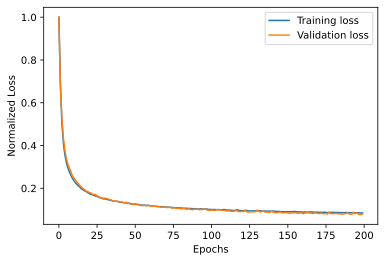

In [22]:
# Plotting the learning curve 
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))

#plt.title('Learning curve')
plt.ylabel('Normalized Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')


In [23]:
## Only the Encoder part
rw_pinn_encoder = Model(inputs=input_final, outputs=encoded)

In [24]:
encoder_output_trainset = rw_pinn_encoder.predict(X_train_final)
phi_trainset_pred=((encoder_output_trainset+1)/2) * (phi_max - phi_min) + phi_min 

In [25]:
encoder_output_testset = rw_pinn_encoder.predict(X_test_final)
phi_testset_pred=((encoder_output_testset+1)/2) * (phi_max - phi_min) + phi_min

In [26]:
phi_trainset_true=Y_train[:,246:246+199] * (phi_max - phi_min) + phi_min
phi_testset_true=Y_test[:,246:246+199] * (phi_max - phi_min) + phi_min


In [27]:
phi_train_error=mean_squared_error(phi_trainset_true,phi_trainset_pred)
phi_test_error=mean_squared_error(phi_testset_true,phi_testset_pred)

print('Porosity Train error:',phi_train_error)
print('Porosity Test error:',phi_test_error)

Porosity Train error: 0.0035885783165125235
Porosity Test error: 0.0036001963172599097


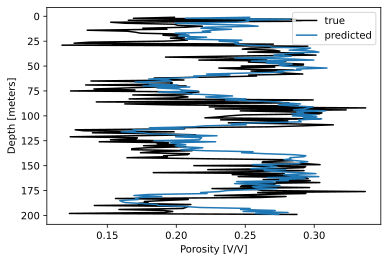

In [28]:
sample_number=400

plt.plot(phi_trainset_true[sample_number, :], depth, color = "black",label='true')
plt.plot(phi_trainset_pred[sample_number, :], depth,label='predicted')
plt.xlabel("Porosity [V/V]")
plt.ylabel("Depth [meters]")
plt.legend()
plt.gca().invert_yaxis()

In [29]:
## Only the Decoder part
rw_pinn_decoder = Model(inputs=encoded, outputs=seis_for_final)

In [30]:
decoder_output_trainset = rw_pinn_decoder.predict(encoder_output_trainset)
seis_output_trainset=decoder_output_trainset[:,0:246]

decoder_output_testset = rw_pinn_decoder.predict(encoder_output_testset)
seis_output_testset=decoder_output_testset[:,0:246]

Text(0, 0.5, 'Time')

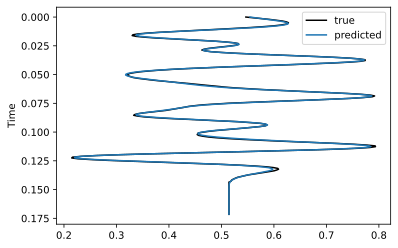

In [31]:
plt.plot(np.squeeze(X_train_final[sample_number,:,:]),time_upscaled, color = "black",label='true')
plt.plot(seis_output_trainset[sample_number,:],time_upscaled,label='predicted')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Time')


In [32]:
encoder_output_set = rw_pinn_encoder.predict(np.expand_dims(np.expand_dims(seis_normalized, axis=1),axis=3))
phi_set_pred=((encoder_output_set+1)/2) * (phi_max - phi_min) + phi_min

decoder_output_set = rw_pinn_decoder.predict(encoder_output_set)
seis_output_set=decoder_output_set[:,0:246]

In [33]:
phi_error=np.sqrt(mean_squared_error(phi_true,phi_set_pred))

print('Porosity RMS error:',phi_error)

Porosity RMS error: 0.05992413467500217


In [34]:
phi_train_error=np.sqrt(mean_squared_error(phi_trainset_true,phi_trainset_pred))
phi_test_error=np.sqrt(mean_squared_error(phi_testset_true,phi_testset_pred))

print('Porosity Trainset RMS error:',phi_train_error)
print('Porosity Testset RMS error:',phi_test_error)

Porosity Trainset RMS error: 0.05990474368956538
Porosity Testset RMS error: 0.06000163595486301


In [35]:
seis_error=np.sqrt(mean_squared_error(seis,seis_output_set*(np.max(seis)-np.min(seis))+ np.min(seis)))
seis_error_train=np.sqrt(mean_squared_error(np.squeeze(X_train_final)*(np.max(seis)-np.min(seis))+ np.min(seis),seis_output_trainset*(np.max(seis)-np.min(seis))+ np.min(seis)))
seis_error_test=np.sqrt(mean_squared_error(np.squeeze(X_test_final)*(np.max(seis)-np.min(seis))+ np.min(seis),seis_output_testset*(np.max(seis)-np.min(seis))+ np.min(seis)))

print('Seismic RMS error:',seis_error)
print('Seismic Train RMS error:',seis_error_train)
print('Seismic Test RMS error:',seis_error_test)

Seismic RMS error: 0.0036077789394322783
Seismic Train RMS error: 0.0035116026074327117
Seismic Test RMS error: 0.003969248401226506


<Figure size 432x288 with 0 Axes>

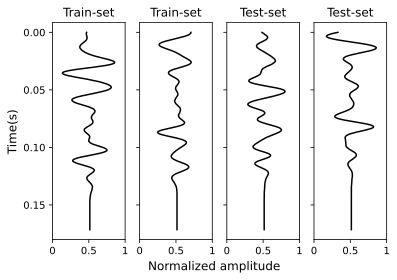

In [36]:
plt.figure()
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(np.squeeze(X_train_final[34,:,:]),time_upscaled,'k')
axs[0].set_yticks([0,0.05,0.1,0.15])
axs[0].set_xticks([0,0.5,1])
axs[0].set_xticklabels(('0','0.5','1'))
axs[0].set_title('Train-set')

axs[1].plot(np.squeeze(X_train_final[64,:,:]),time_upscaled,'k')
axs[1].set_xticks([0,0.5,1])
axs[1].set_xticklabels(('0','0.5','1'))
axs[1].set_title('Train-set')

axs[2].plot(np.squeeze(X_test_final[21,:,:]),time_upscaled,'k')
axs[2].set_xticks([0,0.5,1])
axs[2].set_xticklabels(('0','0.5','1'))
axs[2].set_title('Test-set')

axs[3].plot(np.squeeze(X_test_final[26,:,:]),time_upscaled,'k')
axs[3].set_xticks([0,0.5,1])
axs[3].set_xticklabels(('0','0.5','1'))
axs[3].set_title('Test-set')

fig.supxlabel('Normalized amplitude')
fig.supylabel('Time(s)')

plt.gca().invert_yaxis()

<Figure size 432x288 with 0 Axes>

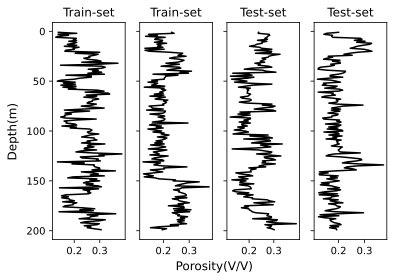

In [37]:
plt.figure()
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(phi_trainset_true[34, :], depth,'k')
axs[0].set_yticks([0,50,100,150,200])
axs[0].set_xticks([0.2,0.3])
axs[0].set_title('Train-set')

axs[1].plot(phi_trainset_true[64, :], depth,'k')
axs[1].set_xticks([0.2,0.3])
axs[1].set_title('Train-set')

axs[2].plot(phi_testset_true[21, :], depth,'k')
axs[2].set_xticks([0.2,0.3])
axs[2].set_title('Test-set')

axs[3].plot(phi_testset_true[26, :], depth,'k')
axs[3].set_xticks([0.2,0.3])
axs[3].set_title('Test-set')

fig.supxlabel('Porosity(V/V)')
fig.supylabel('Depth(m)')

plt.gca().invert_yaxis()

<Figure size 432x288 with 0 Axes>

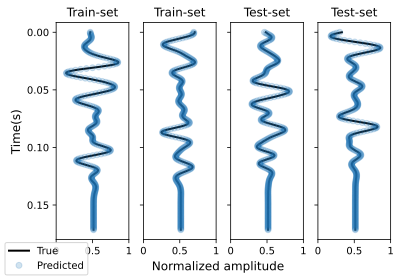

In [38]:
plt.figure()
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(np.squeeze(X_train_final[34,:,:]),time_upscaled,'k',linewidth=2,label='True')
axs[0].plot(seis_output_trainset[34,:],time_upscaled,'o',alpha=0.2,label='Predicted')
axs[0].set_yticks([0,0.05,0.1,0.15])
axs[0].set_xticks([0,0.5,1])
axs[0].set_xticklabels(('0','0.5','1'))
axs[0].set_title('Train-set')

axs[1].plot(np.squeeze(X_train_final[64,:,:]),time_upscaled,'k',linewidth=2)
axs[1].plot(seis_output_trainset[64,:],time_upscaled,'o',alpha=0.2)
axs[1].set_xticks([0,0.5,1])
axs[1].set_xticklabels(('0','0.5','1'))
axs[1].set_title('Train-set')

axs[2].plot(np.squeeze(X_test_final[21,:,:]),time_upscaled,'k',linewidth=2)
axs[2].plot(seis_output_testset[21,:],time_upscaled,'o',alpha=0.2)
axs[2].set_xticks([0,0.5,1])
axs[2].set_xticklabels(('0','0.5','1'))
axs[2].set_title('Test-set')

axs[3].plot(np.squeeze(X_test_final[26,:,:]),time_upscaled,'k',linewidth=2)
axs[3].plot(seis_output_testset[26,:],time_upscaled,'o',alpha=0.2)
axs[3].set_xticks([0,0.5,1])
axs[3].set_xticklabels(('0','0.5','1'))
axs[3].set_title('Test-set')

fig.supxlabel('Normalized amplitude')
fig.supylabel('Time(s)')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')

plt.gca().invert_yaxis()

<Figure size 432x288 with 0 Axes>

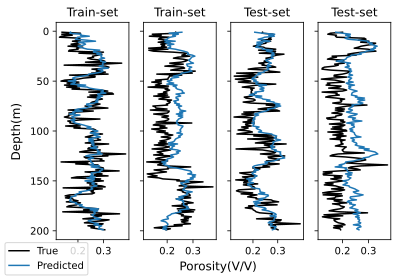

In [39]:
plt.figure()
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(phi_trainset_true[34, :], depth,'k',label='True')
axs[0].plot(phi_trainset_pred[34, :], depth,label='Predicted')
axs[0].set_yticks([0,50,100,150,200])
axs[0].set_xticks([0.2,0.3])
axs[0].set_title('Train-set')

axs[1].plot(phi_trainset_true[64, :], depth,'k')
axs[1].plot(phi_trainset_pred[64, :], depth)
axs[1].set_xticks([0.2,0.3])
axs[1].set_title('Train-set')

axs[2].plot(phi_testset_true[21, :], depth,'k')
axs[2].plot(phi_testset_pred[21, :], depth)
axs[2].set_xticks([0.2,0.3])
axs[2].set_title('Test-set')

axs[3].plot(phi_testset_true[26, :], depth,'k')
axs[3].plot(phi_testset_pred[26, :], depth)
axs[3].set_xticks([0.2,0.3])
axs[3].set_title('Test-set')

fig.supxlabel('Porosity(V/V)')
fig.supylabel('Depth(m)')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')

plt.gca().invert_yaxis()